Preprocess the input excel and prepare the raw input data.

In [ ]:
import io
import pandas as pd
import numpy as np

# Google specific file reading
from google3.pyglib import gfile

# CONSTANTS for input data
FILENAME = '/x20/users/zi/zixiyan/tropical_cyclone_forecast/data/TC_observed_data_sizes.xlsx'
SHEET_NAMES = ['CP_noFillValue', 'EP_noFillValue', 'AL_noFillValue']
VMAX_COLUMN_NAME = 'Vmax(knot)'
RMAX_COLUMN_NAME = 'Rmax(nm)'
R34_COLUMN_NAME = 'R34'
COLUMN_NAMES = [VMAX_COLUMN_NAME, RMAX_COLUMN_NAME, R34_COLUMN_NAME]
DEFAULT_HEADER_COLUMN_NAMES = [
    'name',
    'column2',
    'year',
    'lat(N)',
    'lon(W)',
    'Vmax(knot)',
    'MinSLP(hPa)',
    'Rmax(nm)',
    'eye diameter(nm)',
    'pressure outside(hPa)',
    'Radius of outside(nm)',
    'R34',
    'R50',
    'R64',
    'type',
    'distance of Land',
]

vmax, rmax, r34 = [], [], []

with gfile.GFile(FILENAME) as f:
  raw_bytes = f.read()
  buffer = io.BytesIO(raw_bytes)

  for sheet_name in SHEET_NAMES:
    print('Processing sheet: %s' % sheet_name)
    try:
      df = pd.read_excel(
          buffer, sheet_name=sheet_name, usecols=COLUMN_NAMES, header=0
      )
    except ValueError:
      # Re-read the excel w/o assuming a header row exist
      df = pd.read_excel(buffer, sheet_name=sheet_name, header=None)
      df.columns = DEFAULT_HEADER_COLUMN_NAMES

    vmax = vmax + df[VMAX_COLUMN_NAME].tolist()
    rmax = rmax + df[RMAX_COLUMN_NAME].tolist()
    r34 = r34 + df[R34_COLUMN_NAME].tolist()
    print('Successfully read sheet: %s' % sheet_name)

print(vmax)
print(rmax)
print(r34)

data = np.transpose(np.array([vmax, rmax, r34], dtype=np.float32))
print(data.shape)

Processing sheet: CP_noFillValue
Successfully read sheet: CP_noFillValue
Processing sheet: EP_noFillValue
Successfully read sheet: EP_noFillValue
Processing sheet: AL_noFillValue
Successfully read sheet: AL_noFillValue
[65, 70, 75, 100, 115, 115, 115, 90, 90, 90, 90, 90, 90, 100, 115, 125, 125, 140, 140, 140, 130, 130, 140, 140, 140, 140, 140, 140, 135, 130, 130, 130, 130, 135, 130, 140, 140, 140, 135, 135, 135, 135, 135, 135, 130, 130, 115, 115, 115, 110, 110, 110, 100, 100, 95, 95, 85, 70, 65, 75, 90, 100, 110, 105, 100, 90, 85, 80, 70, 65, 65, 65, 70, 75, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65, 80, 85, 80, 80, 75, 70, 80, 80, 80, 80, 85, 85, 85, 80, 80, 80, 75, 75, 70, 65, 80, 110, 115, 120, 115, 110, 110, 105, 100, 100, 100, 100, 100, 90, 85, 80, 80, 80, 85, 90, 85, 80, 75, 70, 70, 70, 75, 80, 90, 95, 90, 90, 85, 85, 80, 75, 75, 70, 70, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 75, 80, 90, 95, 90, 75, 65, 65, 70, 75, 80, 85, 80, 75, 70, 65, 75, 90, 110, 130, 140, 140, 135, 130, 1

In [ ]:
import copy

from sklearn import preprocessing

# Min-max transformation for 0-1 standardization.
# data = preprocessing.MinMaxScaler().fit_transform(data)
# Standardize transformation
data = preprocessing.StandardScaler().fit_transform(data)
VMIN, VMAX = -10, 10

# Remove outlier
selected_data = []
for row in data:
  if np.any(row < VMIN) or np.any(row > VMAX):
    continue
  selected_data.append(row)
data = np.array(selected_data, dtype=np.float32)

VMIN = max(VMIN, data.min())
VMAX = min(VMAX, data.max())

print(data.shape)
print(data[:, 0].min(), data[:, 0].max())
print(data[:, 1].min(), data[:, 1].max())
print(data[:, 2].min(), data[:, 2].max())

(5724, 3)
-1.1173116 4.7110343
-1.1971186 8.836484
-1.6955273 9.043911


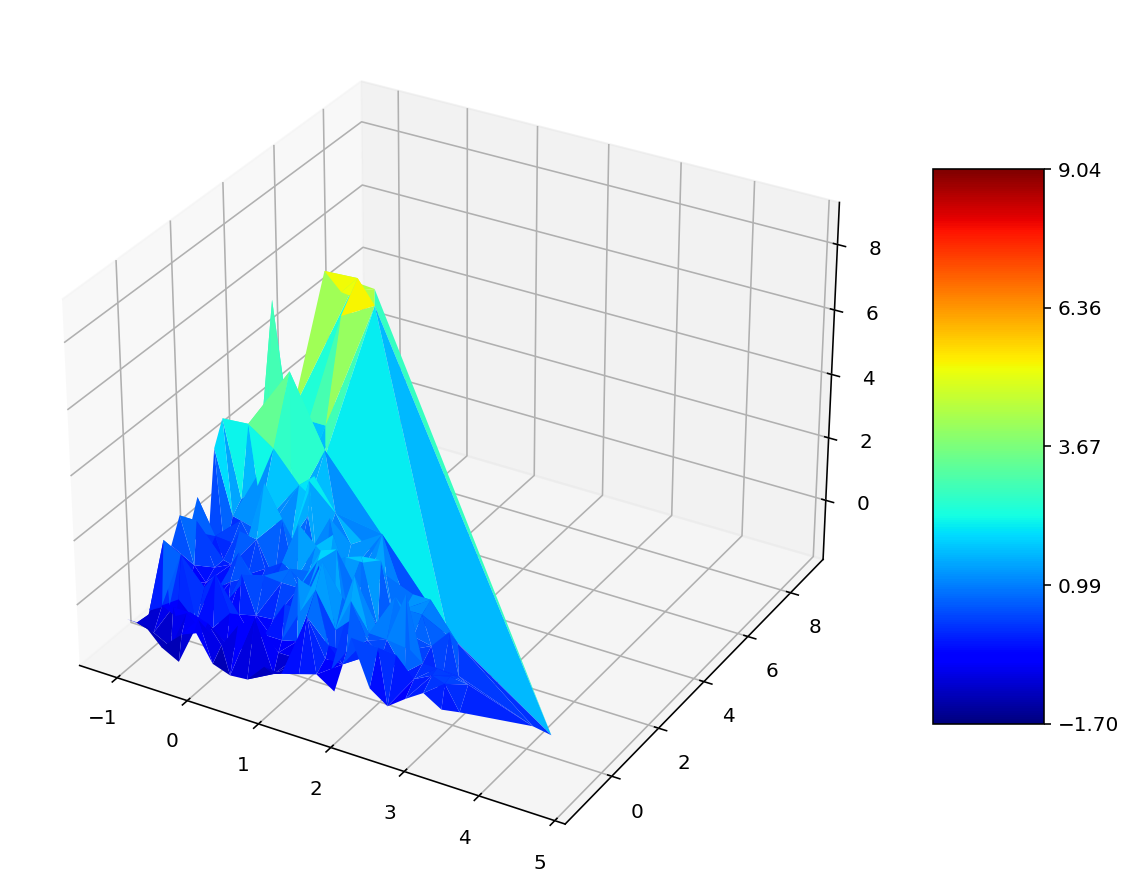

In [ ]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8, 8))

surf = ax.plot_trisurf(data[:, 0], data[:, 1], data[:, 2], cmap=cm.jet, linewidth=0.5, vmin=VMIN, vmax=VMAX)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, orientation='vertical', ticks=LinearLocator(numticks=5))

plt.tight_layout()
plt.show()

In [ ]:
import copy

shuffled_data = copy.deepcopy(data)
np.random.shuffle(shuffled_data)
n = shuffled_data.shape[0]
indexs = [0, int(n * 0.9), n]
train, test = (
    shuffled_data[indexs[0] : indexs[1]],
    shuffled_data[indexs[1] : indexs[2]],
)
print(train.shape)
print(test.shape)

(5151, 3)
(573, 3)


In [ ]:
from colabtools import adhoc_import
from tensorflow import keras

MAX_LAYER_NODES = 64
MAX_NUM_LAYERS = 16


def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Input(shape=(2,), name='input'))

  # Add hidden layers with different nodes but with the same activation
  # function. Number of nodes are tuned separately.
  for i in range(
      hp.Int('num_layers', min_value=2, max_value=MAX_LAYER_NODES, step=2)
  ):
    model.add(
        keras.layers.Dense(
            name='hidden_layer_%d' % i,
            units=hp.Int(
                'units_%d' % i, min_value=4, max_value=MAX_NUM_LAYERS, step=2
            ),
            activation=hp.Choice(
                'activation',
                [
                    'tanh',
                    'sigmoid',
                    # 'relu',
                ],
            ),
            use_bias=True,
        )
    )

  # The output layer only gives one value with sigmoid as the activation
  # function to make the output value in [0, 1].
  # model.add(keras.layers.Dense(name='output', units=1, activation='sigmoid'))
  model.add(keras.layers.Dense(name='output', units=1, use_bias=True))

  model.summary()

  model.compile(
      optimizer=keras.optimizers.SGD(
          learning_rate=hp.Float(
              'learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'
          )
      ),
      loss='mse',
  )
  return model


with adhoc_import.Google3SubmittedChangelist():
  import keras_tuner

  model = build_model(keras_tuner.HyperParameters())
  tuner = keras_tuner.BayesianOptimization(
      hypermodel=build_model,
      objective='val_loss',
      max_trials=20,
      num_initial_points=20,
      alpha=0.0001,
      beta=2.6,
      seed=128,
      tune_new_entries=True,
      allow_new_entries=True,
      max_retries_per_trial=0,
      max_consecutive_failed_trials=3,
      overwrite=True,
  )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_0 (Dense)      (None, 4)                 12        
                                                                 
 hidden_layer_1 (Dense)      (None, 4)                 20        
                                                                 
 output (Dense)              (None, 1)                 5         
                                                                 
Total params: 37 (148.00 Byte)
Trainable params: 37 (148.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_0 (Dense)      (None, 4)                 12        
                                                              

In [ ]:
tuner.search(
    train[:, 0:2],
    train[:, 2],
    epochs=2,
    batch_size=32,
    validation_split=0.1,
)
tuner.get_best_models(num_models=1)[0].summary()

Trial 20 Complete [00h 00m 12s]
val_loss: 0.9500997066497803

Best val_loss So Far: 0.628757119178772
Total elapsed time: 00h 03m 01s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_0 (Dense)      (None, 8)                 24        
                                                                 
 hidden_layer_1 (Dense)      (None, 4)                 36        
                                                                 
 hidden_layer_2 (Dense)      (None, 4)                 20        
                                                                 
 hidden_layer_3 (Dense)      (None, 8)                 40        
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 129 (516.00 Byte)
Trainable params: 129 

best_hp:  <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x70e6735a2fd0>
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_0 (Dense)      (None, 8)                 24        
                                                                 
 hidden_layer_1 (Dense)      (None, 4)                 36        
                                                                 
 hidden_layer_2 (Dense)      (None, 4)                 20        
                                                                 
 hidden_layer_3 (Dense)      (None, 8)                 40        
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 129 (516.00 Byte)
Trainable params: 129 (516.00 Byte)
Non-trainable 

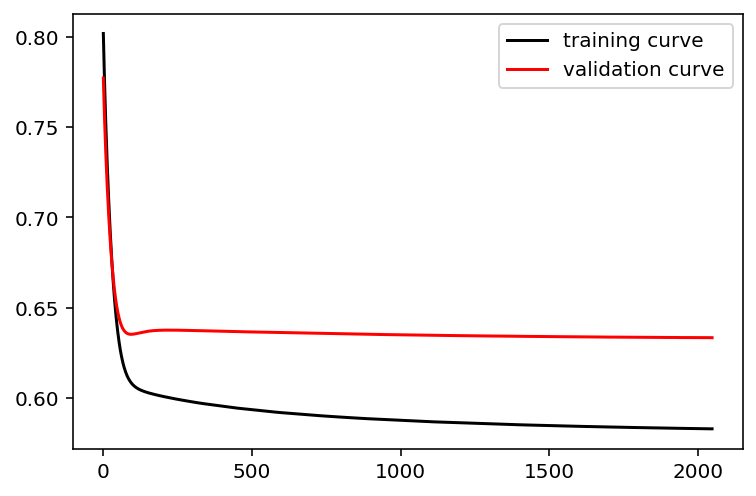

In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print('best_hp: ', best_hp)
best_model = build_model(best_hp)

# Converge around ~1200
NUM_EPOCHS = 2048
# NUM_EPOCHS = 128

history = model.fit(
    train[:, 0:2],
    train[:, 2],
    epochs=NUM_EPOCHS,
    batch_size=32,
    validation_split=0.1,
)

plt.plot(
    range(0, NUM_EPOCHS), history.history['loss'], c='k', label='training curve'
)
plt.plot(
    range(0, NUM_EPOCHS),
    history.history['val_loss'],
    c='r',
    label='validation curve',
)
plt.legend()
plt.show()


18/18 [==============================] - 0s 1ms/step


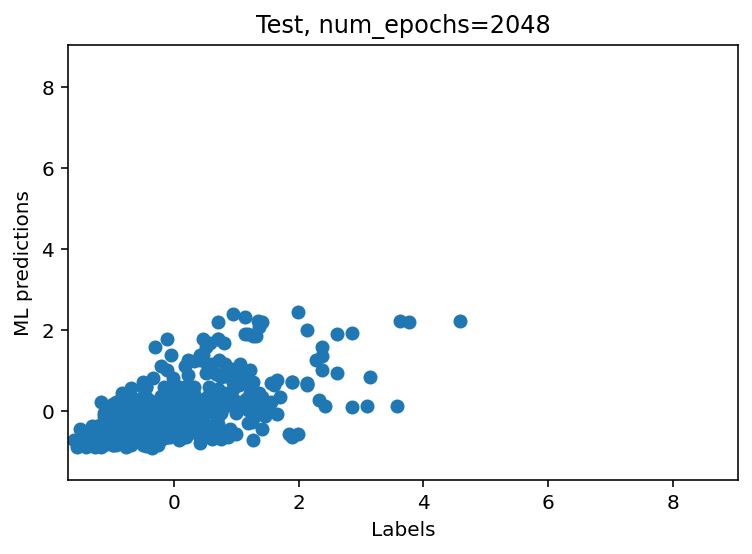

0.6167318560228886


In [ ]:
model.evaluate(test[:, 0:2], test[:, 2], verbose=True)

predict_on_test = model.predict(test[:, 0:2]).flatten()

plt.scatter(x=test[:,2], y=predict_on_test)
plt.xlim(VMIN, VMAX)
plt.ylim(VMIN, VMAX)
plt.xlabel('Labels')
plt.ylabel('ML predictions')
plt.title('Test, num_epochs=%d' % NUM_EPOCHS)
plt.show()

corr = np.corrcoef(predict_on_test, test[:, 2])
print(corr[0, 1])

161/161 [==============================] - 0s 997us/step


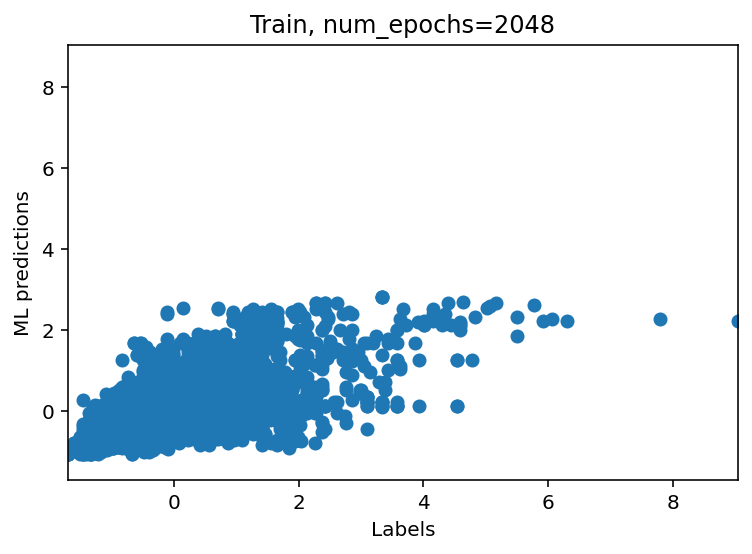

0.6167318560228886


In [ ]:
predict_on_train = model.predict(train[:, 0:2]).flatten()
plt.scatter(x=train[:,2], y=predict_on_train)
plt.xlim(VMIN, VMAX)
plt.ylim(VMIN, VMAX)
plt.xlabel('Labels')
plt.ylabel('ML predictions')
plt.title('Train, num_epochs=%d' % NUM_EPOCHS)
plt.show()

corr = np.corrcoef(predict_on_test, test[:, 2])
print(corr[0, 1])

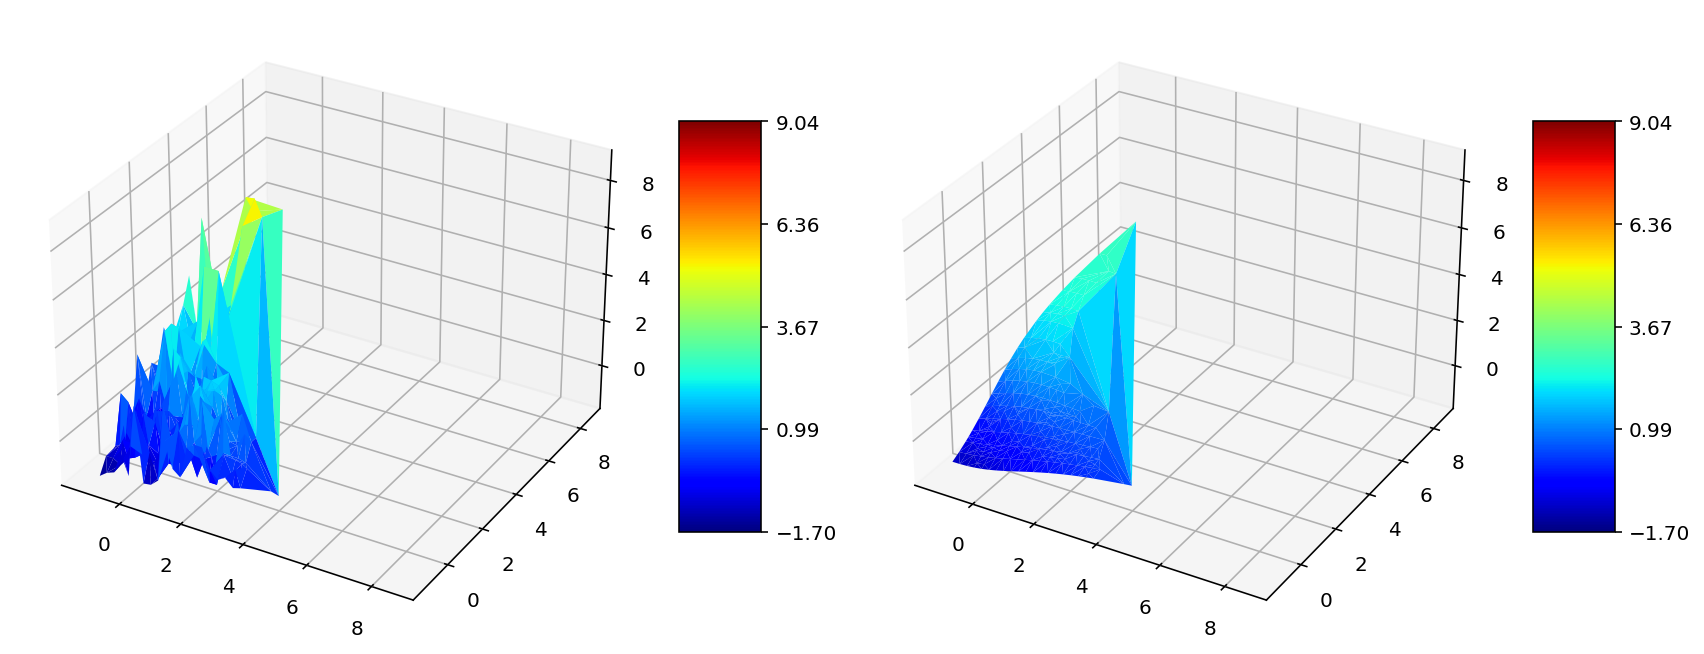

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 6))
ax1.set_xlim(VMIN, VMAX)
ax1.set_ylim(VMIN, VMAX)
ax1.set_zlim(VMIN, VMAX)
ax2.set_xlim(VMIN, VMAX)
ax2.set_ylim(VMIN, VMAX)
ax2.set_zlim(VMIN, VMAX)

surf1 = ax1.plot_trisurf(train[:,0], train[:,1], train[:,2], cmap=cm.jet, linewidth=1, vmin=VMIN, vmax=VMAX)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5, orientation='vertical', ticks=LinearLocator(numticks=5))

surf2 = ax2.plot_trisurf(train[:,0], train[:,1], predict_on_train, cmap=cm.jet, linewidth=1, vmin=VMIN, vmax=VMAX)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5, orientation='vertical', ticks=LinearLocator(numticks=5))

plt.title('Train set, num_epochs=%d' % NUM_EPOCHS)
plt.tight_layout()
plt.show()

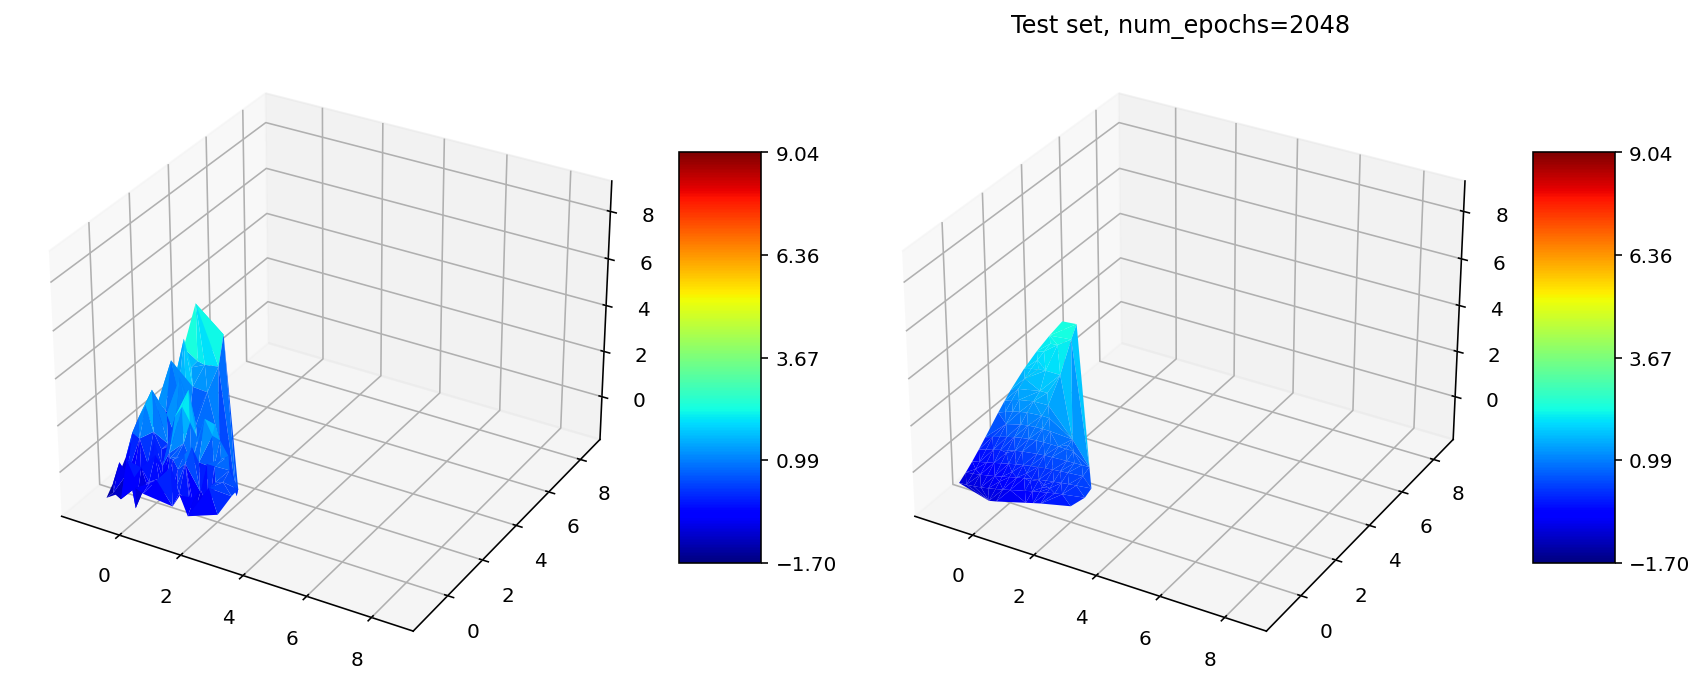

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 6))
ax1.set_xlim(VMIN, VMAX)
ax1.set_ylim(VMIN, VMAX)
ax1.set_zlim(VMIN, VMAX)
ax2.set_xlim(VMIN, VMAX)
ax2.set_ylim(VMIN, VMAX)
ax2.set_zlim(VMIN, VMAX)

surf1 = ax1.plot_trisurf(test[:,0], test[:,1], test[:,2], cmap=cm.jet, linewidth=1, vmin=VMIN, vmax=VMAX)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5, orientation='vertical', ticks=LinearLocator(numticks=5))

surf2 = ax2.plot_trisurf(test[:,0], test[:,1], predict_on_test, cmap=cm.jet, linewidth=1, vmin=VMIN, vmax=VMAX)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5, orientation='vertical', ticks=LinearLocator(numticks=5))

plt.title('Test set, num_epochs=%d' % NUM_EPOCHS)
plt.tight_layout()
plt.show()